# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [37]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

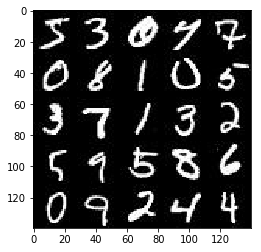

In [38]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

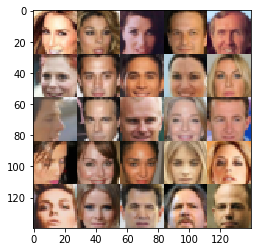

In [39]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [41]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_image')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_image, z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [44]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.2 * x1, x1)
        d1 = tf.nn.dropout(relu1, 0.5)
    
        x2 = tf.layers.conv2d(d1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        d2 = tf.nn.dropout(relu2, 0.5)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        d3 = tf.nn.dropout(relu3, 0.5)
        
        flatten = tf.reshape(d3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [45]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_out = generator(input_z, out_channel_dim)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_real_logits,
                                    labels=tf.ones_like(d_real_out) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_fake_logits,
                                    labels=tf.zeros_like(d_fake_out)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(
                                     logits=d_fake_logits,
                                     labels=tf.ones_like(d_fake_out)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_vars = tf.trainable_variables()
    g_vars = [var for var in all_vars if var.name.startswith('generator')]
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #(-0.5 to 0.5)
                steps += 1
                
                image_input = batch_images * 2 
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: image_input, 
                                               input_z: batch_z, 
                                               learn_rate:learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: image_input, 
                                               input_z: batch_z, 
                                               learn_rate:learning_rate})
                
                
                loss_d_train = d_loss.eval({input_z:batch_z,
                                            input_real:image_input})
                
                loss_g_trian = g_loss.eval({input_z:batch_z})
                
                if steps % 10 == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                           "Discriminator Loss: {:.4f}...".format(loss_d_train),
                           "Generator Loss: {:.4f}".format(loss_g_trian))   
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
            show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)            

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.2200... Generator Loss: 8.2083
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 15.0683
Epoch 1/2... Discriminator Loss: 0.0134... Generator Loss: 10.3215
Epoch 1/2... Discriminator Loss: 0.0555... Generator Loss: 5.6529
Epoch 1/2... Discriminator Loss: 2.0688... Generator Loss: 1.4936
Epoch 1/2... Discriminator Loss: 0.3097... Generator Loss: 2.6375
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 0.1101... Generator Loss: 4.3887
Epoch 1/2... Discriminator Loss: 0.4308... Generator Loss: 3.2288
Epoch 1/2... Discriminator Loss: 0.5787... Generator Loss: 2.1702


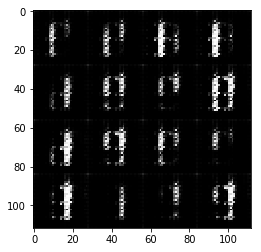

Epoch 1/2... Discriminator Loss: 2.0336... Generator Loss: 0.5031
Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 2.6041
Epoch 1/2... Discriminator Loss: 0.3241... Generator Loss: 4.2004
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 1.1805
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 0.2982... Generator Loss: 3.3372
Epoch 1/2... Discriminator Loss: 0.2477... Generator Loss: 3.9405
Epoch 1/2... Discriminator Loss: 0.5731... Generator Loss: 2.9786
Epoch 1/2... Discriminator Loss: 0.7643... Generator Loss: 1.6542
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 1.1152


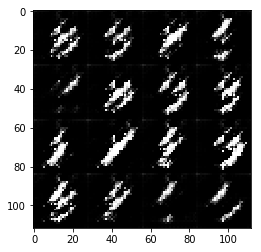

Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 1.8072
Epoch 1/2... Discriminator Loss: 0.1372... Generator Loss: 5.7031
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 1.7350
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 3.7329
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 2.7580
Epoch 1/2... Discriminator Loss: 0.4153... Generator Loss: 2.5739
Epoch 1/2... Discriminator Loss: 0.4923... Generator Loss: 2.5317
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.7706
Epoch 1/2... Discriminator Loss: 0.4569... Generator Loss: 3.1816
Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 2.6404


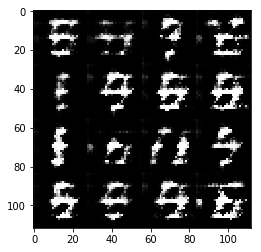

Epoch 1/2... Discriminator Loss: 0.3656... Generator Loss: 2.4865
Epoch 1/2... Discriminator Loss: 1.9095... Generator Loss: 0.8367
Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 1.8798
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 1.3044
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 1.3672
Epoch 1/2... Discriminator Loss: 0.4992... Generator Loss: 2.2193
Epoch 1/2... Discriminator Loss: 0.4495... Generator Loss: 2.2781
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 3.6537
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 0.4824... Generator Loss: 2.8387


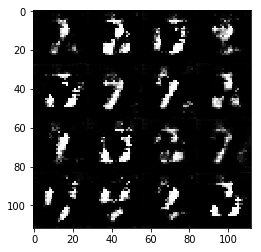

Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 1.2515
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 3.4200
Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 3.0218
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.7994
Epoch 1/2... Discriminator Loss: 0.7532... Generator Loss: 1.4993
Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 2.6692
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 2.4008
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.6754
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 1.8041
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.2073


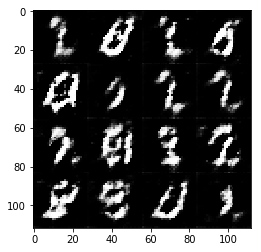

Epoch 1/2... Discriminator Loss: 0.8193... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 0.5527... Generator Loss: 1.8292
Epoch 1/2... Discriminator Loss: 0.6335... Generator Loss: 1.4977
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 1.8598
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 2.6157
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 2.5061
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 2.5868
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.9918
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 2.3302


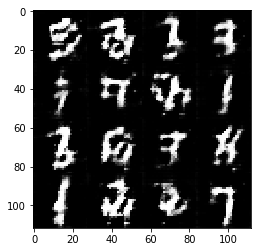

Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.8855
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 2.0886
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 1.2393
Epoch 1/2... Discriminator Loss: 0.5979... Generator Loss: 1.8155
Epoch 1/2... Discriminator Loss: 1.5925... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 1.8573
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 0.9966


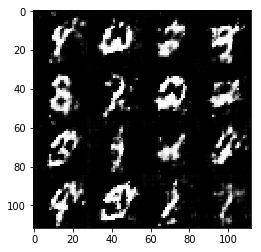

Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.1843
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.1341
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 1.4094
Epoch 1/2... Discriminator Loss: 0.7180... Generator Loss: 1.6207
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 2.5950
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 1.5495
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.5279


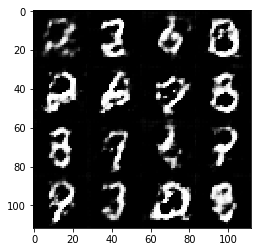

Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 1.6448
Epoch 1/2... Discriminator Loss: 0.6495... Generator Loss: 1.1800
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 1.4904
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.5979
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 1.9638
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 1.5208
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.6242
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 0.8578... Generator Loss: 1.8294
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 1.5403


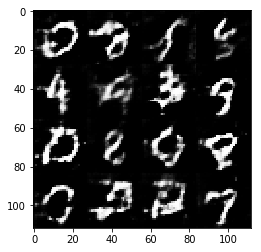

Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 1.2778
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 1.2761
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 0.9431
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 1.6849
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 1.8731
Epoch 1/2... Discriminator Loss: 1.7635... Generator Loss: 0.3839
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 1.2954
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.7071


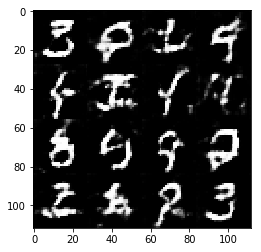

Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.6565
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 0.9255
Epoch 1/2... Discriminator Loss: 1.0062... Generator Loss: 1.8317
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 1.1710
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.8660
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 0.9607


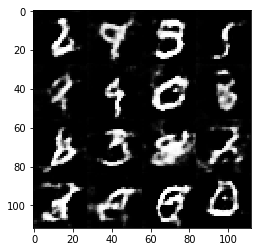

Epoch 1/2... Discriminator Loss: 1.6893... Generator Loss: 0.8929
Epoch 1/2... Discriminator Loss: 0.7464... Generator Loss: 1.8231
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 1.8261
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.7583
Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 1.4924


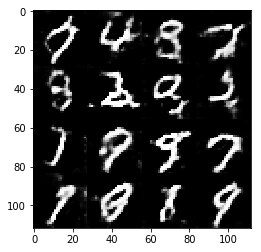

Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 1.1544
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 1.4608
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 1.4993
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.8816
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 1.3152
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.0347... Generator Loss: 1.1229


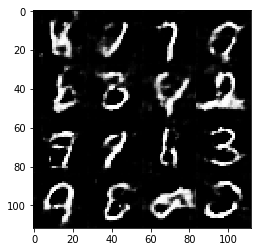

Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 1.4669
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.9635
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 1.1382
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 1.3196
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.1448
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.0413... Generator Loss: 1.3058
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 1.9656
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.9261


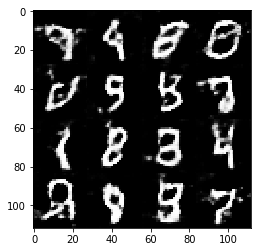

Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.9701
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 1.1648
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 1.2835
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 1.6715
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 1.2835
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.4589
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 1.3070


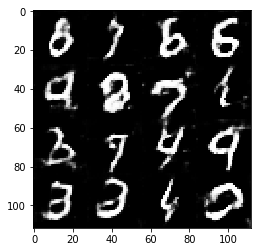

Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 0.6041
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 0.5377
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 1.4890
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 1.1927
Epoch 1/2... Discriminator Loss: 1.2679... Generator Loss: 1.7035


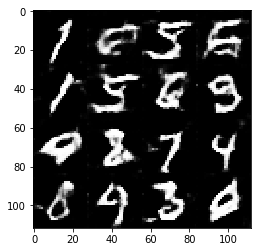

Epoch 1/2... Discriminator Loss: 1.6888... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.2491... Generator Loss: 1.3043
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.8163
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 1.3480
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 1.9024
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.7291


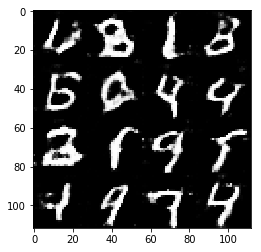

Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 1.0323
Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 3.0984
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.9834
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 1.5357
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.0562
Epoch 1/2... Discriminator Loss: 1.6086... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 1.1479
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.3814
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 1.0117


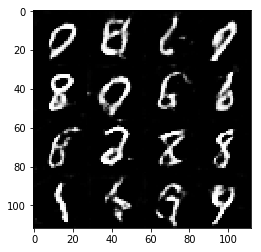

Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 0.9590
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 1.5380
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.4924
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.5438


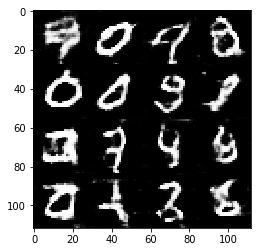

Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.5909
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.7659


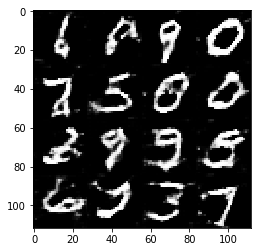

Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 1.3966
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.1796
Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 1.2393
Epoch 2/2... Discriminator Loss: 0.9999... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.5640
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 1.3849
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 1.7341


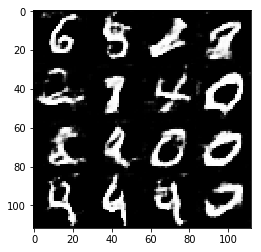

Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 1.1626
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.4334
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 2.4543
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 1.3814
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.3040
Epoch 2/2... Discriminator Loss: 0.9254... Generator Loss: 1.2342
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.7976
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 1.6386
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 2.6869


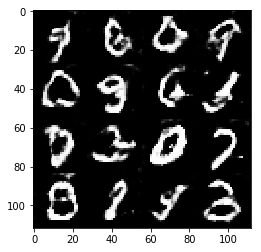

Epoch 2/2... Discriminator Loss: 0.9710... Generator Loss: 0.9332
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 1.2878
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.6088
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 1.2779
Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 1.0669
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.4697
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.5975


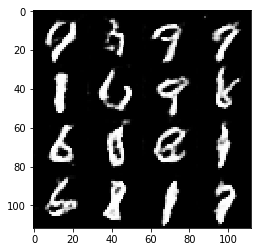

Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 1.4168
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.4297
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 1.2071
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 1.3248
Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 1.8675
Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 1.2151
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.0391


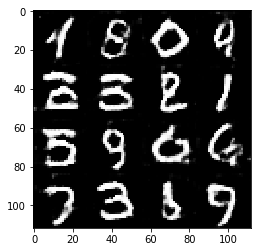

Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 1.5294
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 0.6237
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 1.3206
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.3012
Epoch 2/2... Discriminator Loss: 1.0451... Generator Loss: 1.2672
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 1.1343


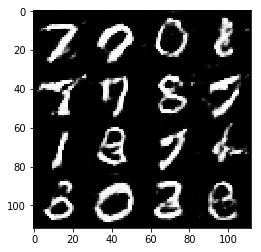

Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 1.4511
Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 1.4468
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 2.4213
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 0.9563
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 1.3699
Epoch 2/2... Discriminator Loss: 1.5526... Generator Loss: 0.2944


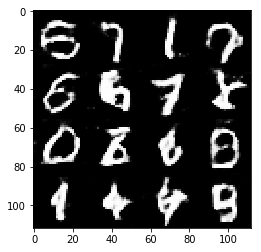

Epoch 2/2... Discriminator Loss: 1.4133... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 1.5139... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 1.5693... Generator Loss: 0.5528
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 0.9718
Epoch 2/2... Discriminator Loss: 1.0587... Generator Loss: 0.9303
Epoch 2/2... Discriminator Loss: 1.2397... Generator Loss: 1.9057
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.6532


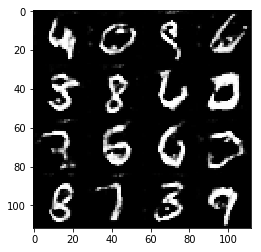

Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.4798... Generator Loss: 1.3615
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.4826
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 0.9168... Generator Loss: 1.3531
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 2.0159
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 1.0968


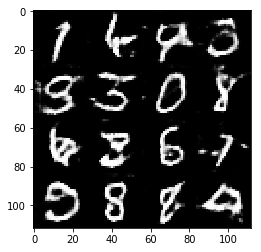

Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 3.0744
Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 1.0762
Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 0.6120
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 1.0975
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 2.0298
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 1.4114
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 1.4331
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.7598
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 1.5853
Epoch 2/2... Discriminator Loss: 1.1317... Generator Loss: 1.8989


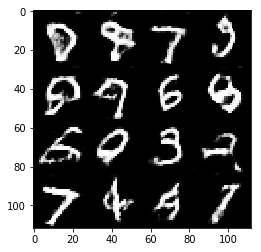

Epoch 2/2... Discriminator Loss: 1.4664... Generator Loss: 1.0985
Epoch 2/2... Discriminator Loss: 1.1530... Generator Loss: 1.8138
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 1.0281
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 1.2506
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 1.2619
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 2.0305
Epoch 2/2... Discriminator Loss: 0.9315... Generator Loss: 1.4153
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 1.9182


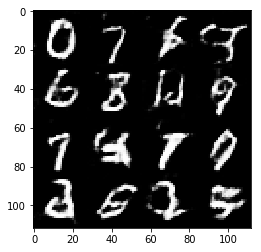

Epoch 2/2... Discriminator Loss: 0.6324... Generator Loss: 1.8886
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 1.5102
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.0675
Epoch 2/2... Discriminator Loss: 0.7429... Generator Loss: 1.3220
Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 1.2057
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 1.3786
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 2.1676
Epoch 2/2... Discriminator Loss: 1.4733... Generator Loss: 1.2889
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 0.9311


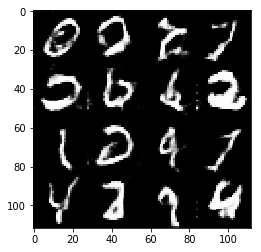

Epoch 2/2... Discriminator Loss: 0.9970... Generator Loss: 1.4808
Epoch 2/2... Discriminator Loss: 1.0366... Generator Loss: 1.5737
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.1898... Generator Loss: 0.9476
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 1.1069
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.6334
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.3158
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.9477... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.1123... Generator Loss: 1.2868


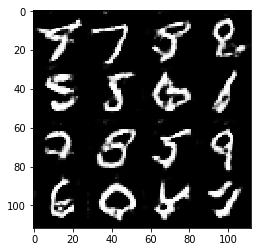

Epoch 2/2... Discriminator Loss: 1.4546... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 1.8018
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 1.5638
Epoch 2/2... Discriminator Loss: 1.5487... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 1.2309
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 1.1970
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.5686
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 1.2464


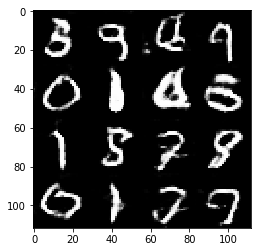

Epoch 2/2... Discriminator Loss: 1.4646... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 1.4922... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 0.9347
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 2.2425
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 1.2357
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 1.4886
Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 1.6291
Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 1.6013
Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 0.5582


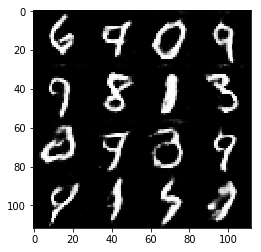

Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 1.2367
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.3666
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.2987
Epoch 2/2... Discriminator Loss: 0.6975... Generator Loss: 2.3362
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.4700
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 0.7952
Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.6631
Epoch 2/2... Discriminator Loss: 1.4953... Generator Loss: 1.2022


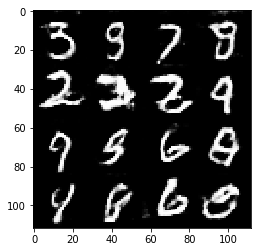

Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 1.5983
Epoch 2/2... Discriminator Loss: 0.7675... Generator Loss: 1.2010
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 1.5715
Epoch 2/2... Discriminator Loss: 1.1296... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.4176
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 1.2169
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 1.5016
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 1.1406
Epoch 2/2... Discriminator Loss: 1.5935... Generator Loss: 1.5130


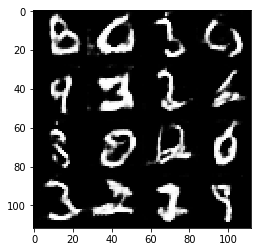

Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.4363
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 1.2474
Epoch 2/2... Discriminator Loss: 1.6435... Generator Loss: 0.4836
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.4702
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.4894
Epoch 2/2... Discriminator Loss: 2.2564... Generator Loss: 0.2364
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 1.6013


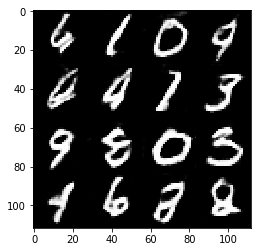

Epoch 2/2... Discriminator Loss: 0.7155... Generator Loss: 2.3736
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 0.9771
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.9664
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 1.3388
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.7321
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.1095
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 0.4811
Epoch 2/2... Discriminator Loss: 1.4991... Generator Loss: 0.8823
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 1.1184


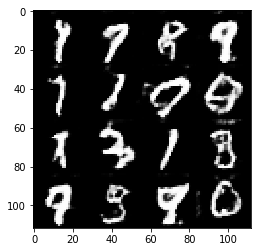

Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 1.3544
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 1.4006
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.8940


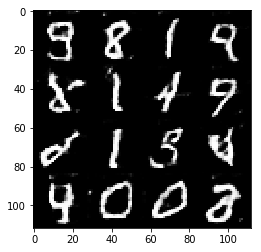

In [48]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.3603
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 2.3215... Generator Loss: 0.1810
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 4.4653
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 9.8353
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 9.8995
Epoch 1/1... Discriminator Loss: 2.7827... Generator Loss: 0.2022
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 4.3827
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 0.2655... Generator Loss: 3.5510


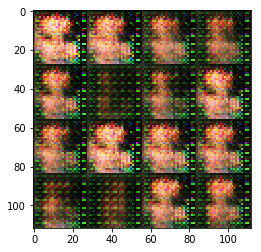

Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 1.9464
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 3.6439
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 2.1880... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.9278... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.7775... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.6062... Generator Loss: 2.3553
Epoch 1/1... Discriminator Loss: 1.7432... Generator Loss: 0.7803


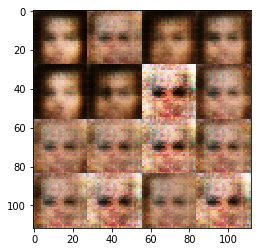

Epoch 1/1... Discriminator Loss: 1.7790... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.7748... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.8463... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 1.4551
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.8262... Generator Loss: 0.8605


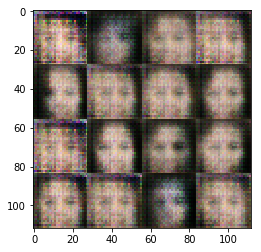

Epoch 1/1... Discriminator Loss: 1.7215... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.8318... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.6310


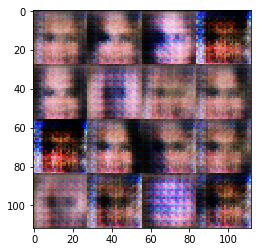

Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 2.1841... Generator Loss: 0.3425
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.9619... Generator Loss: 0.2928
Epoch 1/1... Discriminator Loss: 2.1177... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6860


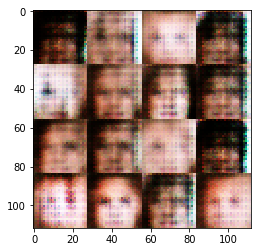

Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.7563... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.9290... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 1.1047


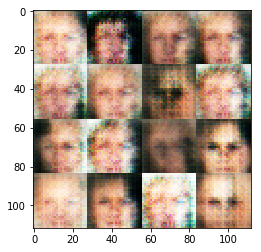

Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6791


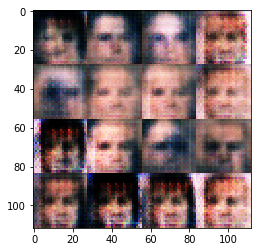

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 2.1699... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 0.7749


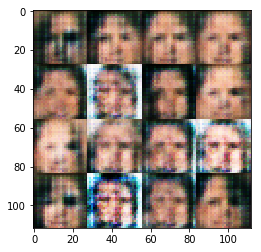

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 1.5851
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.6689


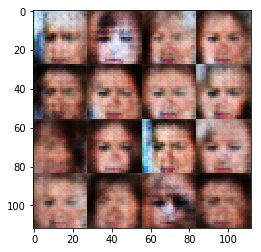

Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.6648... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6939


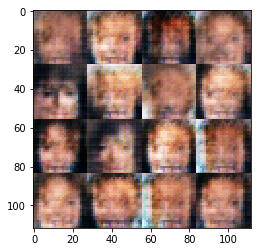

Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.2552
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7464


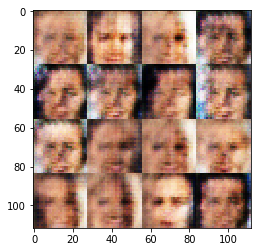

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.7530... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.9643


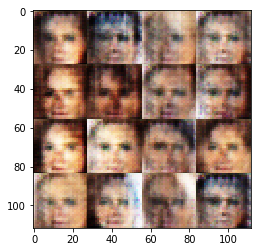

Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 1.7983... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.3244
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 1.0909


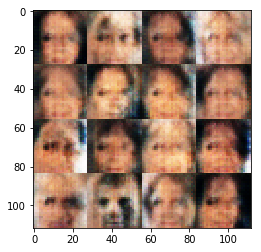

Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.7220... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 0.7468


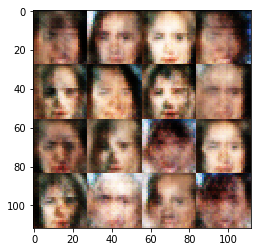

Epoch 1/1... Discriminator Loss: 1.7180... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6855


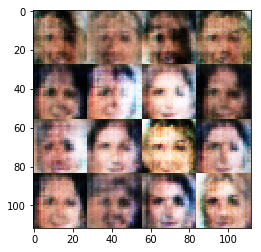

Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 1.8809


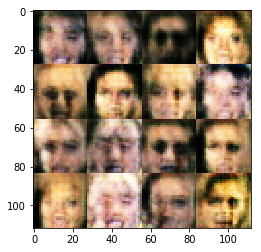

Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8666


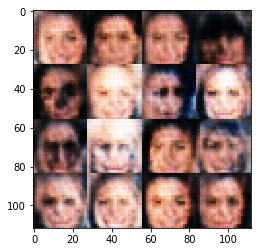

Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.9629
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6850


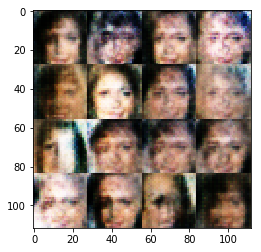

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.7801
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.4766
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.8183


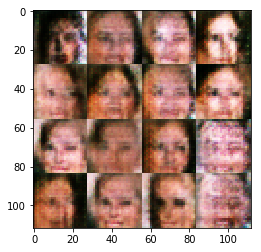

Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.5666


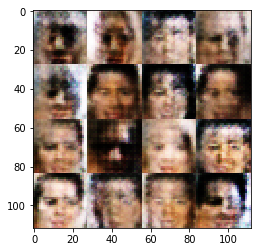

Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7504


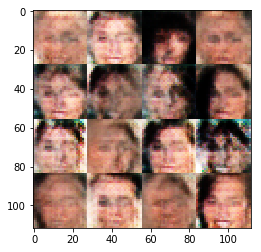

Epoch 1/1... Discriminator Loss: 1.9550... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.8892... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 1.0037


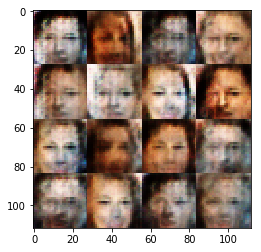

Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 1.7604
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7053


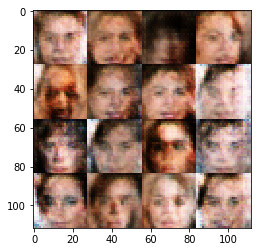

Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 1.3252


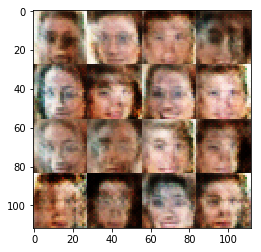

Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6504


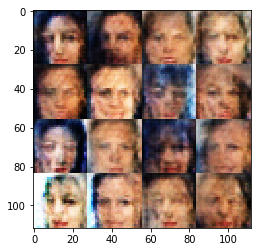

Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.0375


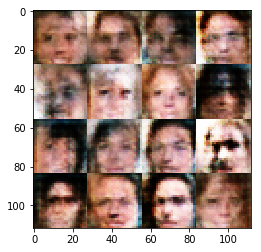

Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.7253... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 1.1924


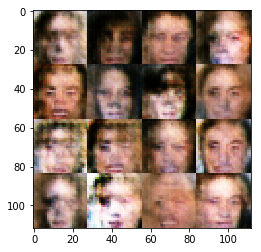

Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.3737
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.6474


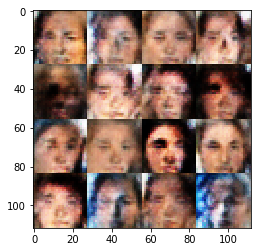

Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.6723


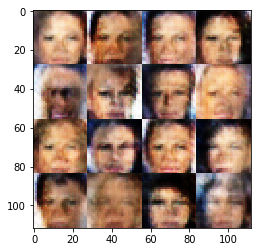

Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.9404


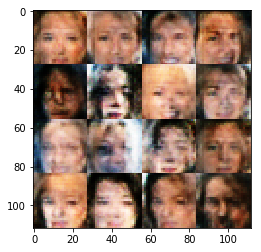

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.1884


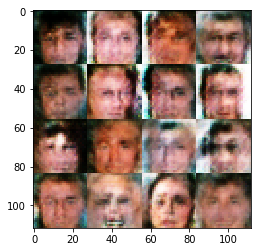

Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.5810


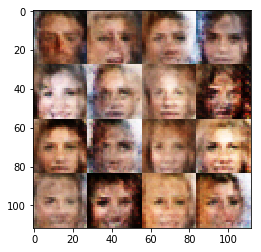

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8490


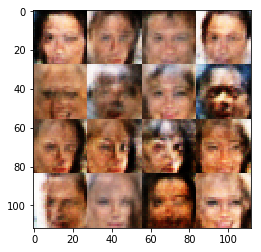

Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.8857


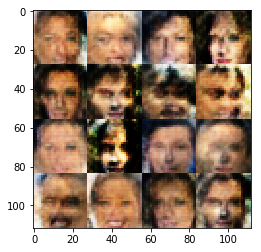

Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 1.6298... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 0.5816


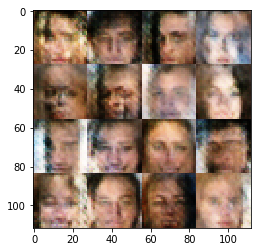

Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.6397... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.8413


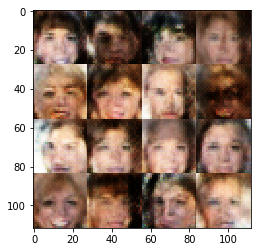

Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.9145


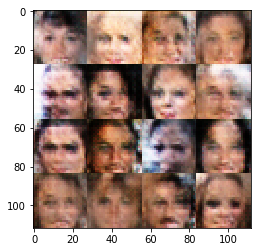

Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.6690... Generator Loss: 0.9391


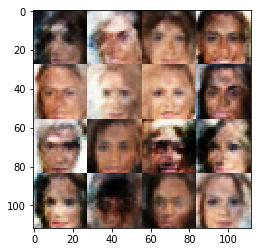

Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7990


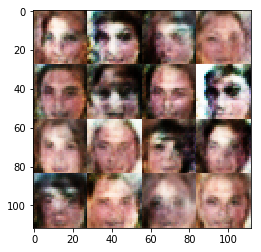

Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.5682... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8638


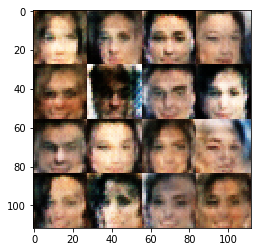

Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.8696


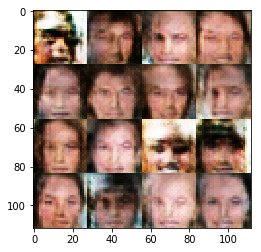

Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8976


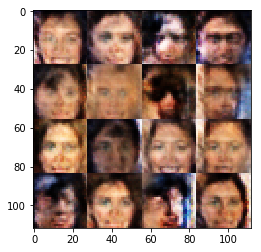

Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.9483


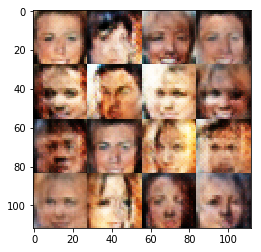

Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8213


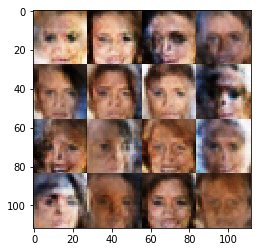

Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.6285


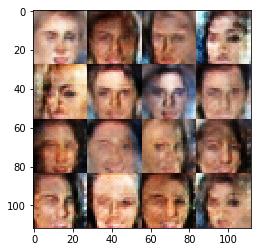

Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.8100


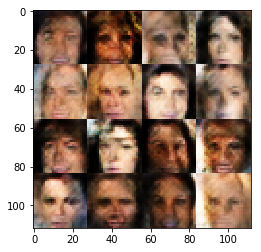

Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6410


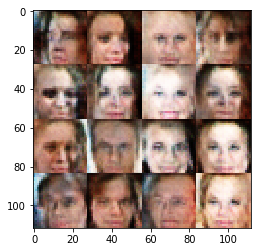

Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.9111


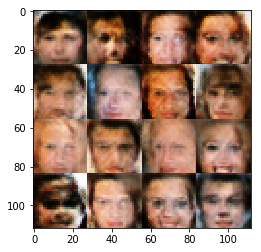

Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.6485... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7766


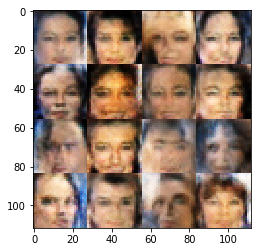

Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.9296


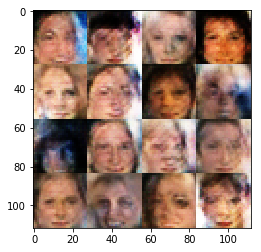

Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.8333


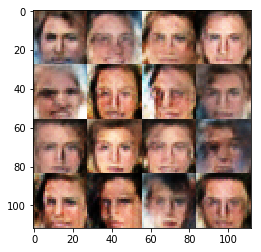

Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6862


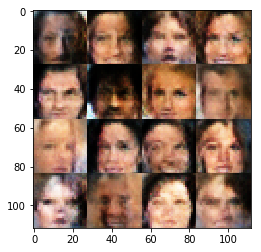

Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6806


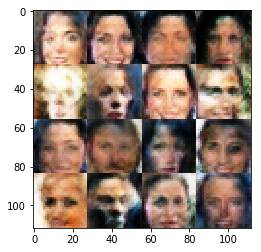

Epoch 1/1... Discriminator Loss: 1.8490... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6033


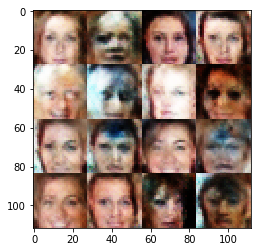

Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8295


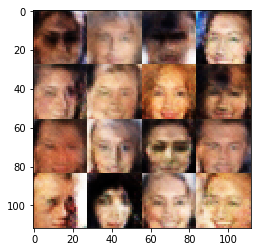

Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.6959... Generator Loss: 0.7549


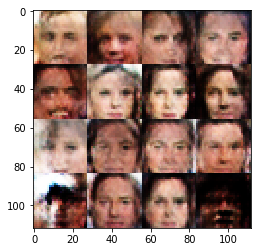

Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.6874


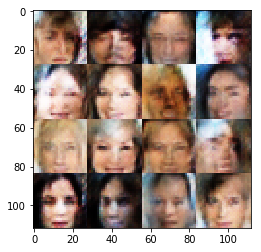

Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.0019


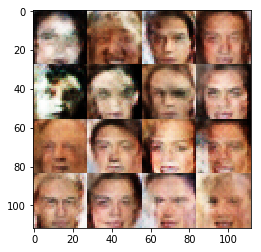

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.7678


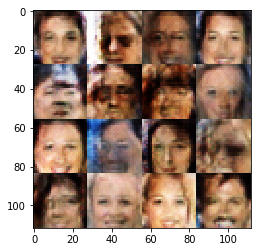

Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8736


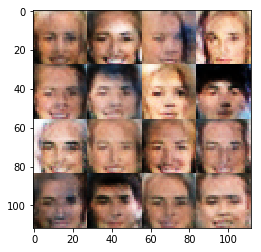

Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8652


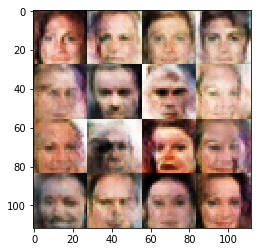

Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7729


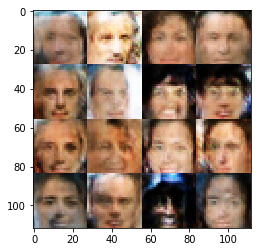

Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6754


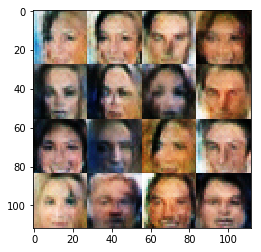

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6069


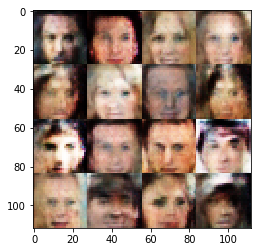

Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.4497
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.7426


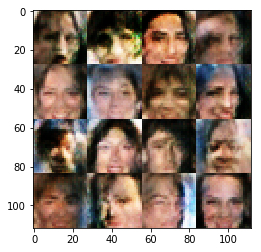

Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.9118


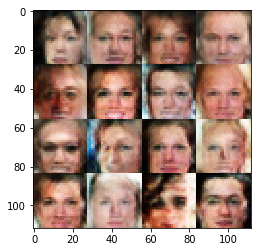

Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.5110


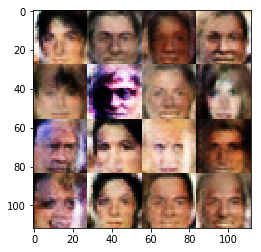

Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7006


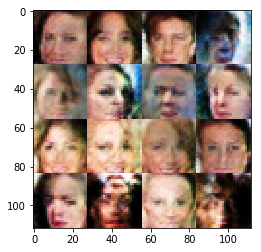

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7833


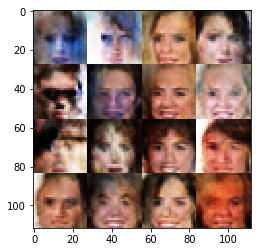

Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.7709


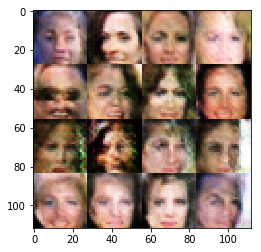

Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.6461


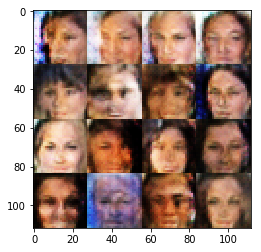

Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.8651


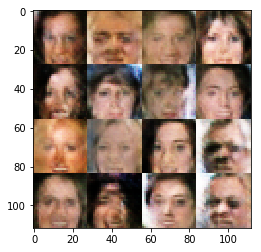

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.0772


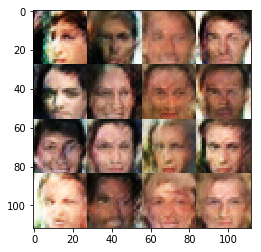

Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.0405


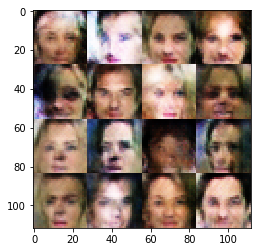

Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.8567


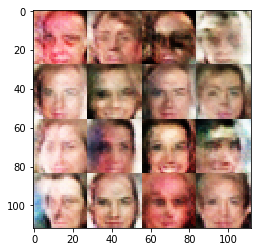

Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7700


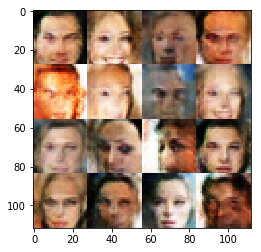

Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7183


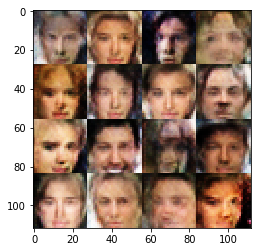

Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.7162


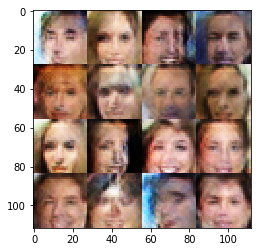

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.9898


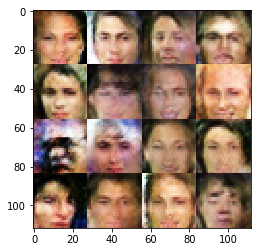

Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7427


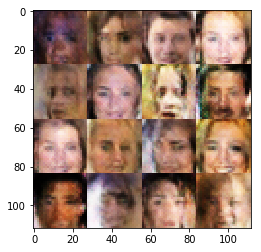

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8700


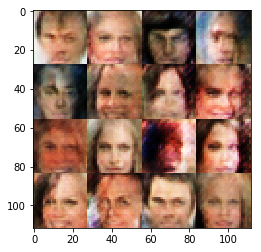

Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.9349


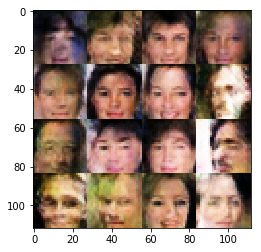

Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.6871


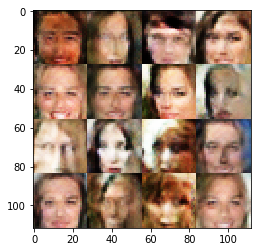

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.0751


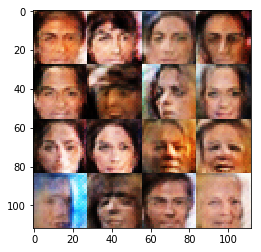

Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.9502


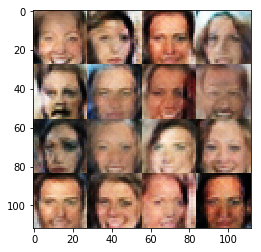

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7344


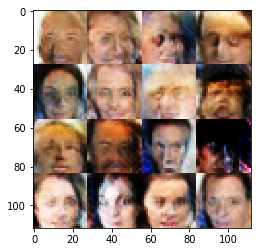

Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7505


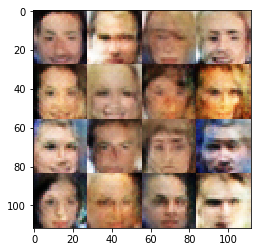

Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7350


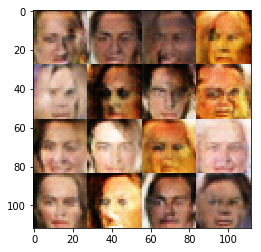

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.6970


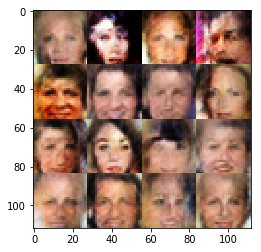

Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.6577


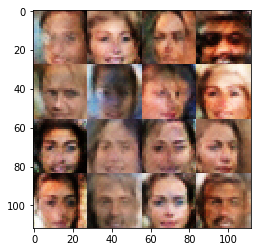

Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8378


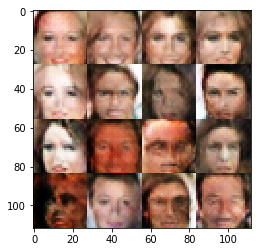

Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7619


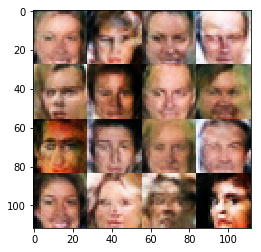

Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.4634


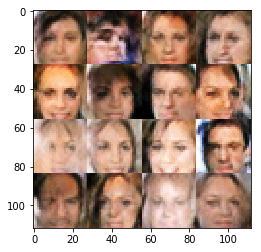

Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 0.8938


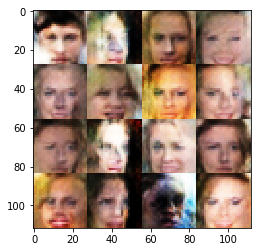

Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.1561


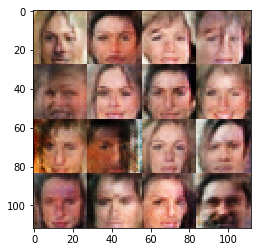

Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.6852


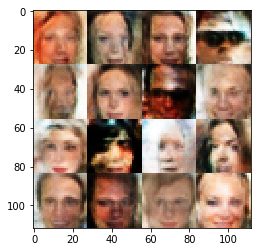

Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6472


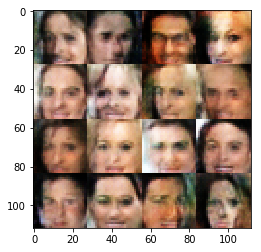

Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.9187


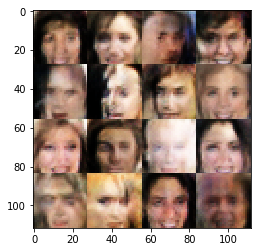

Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.9236


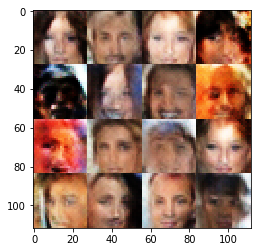

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8877


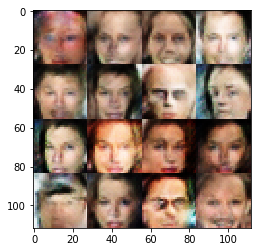

Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.7362


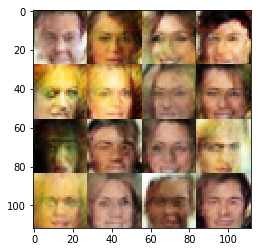

Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6501


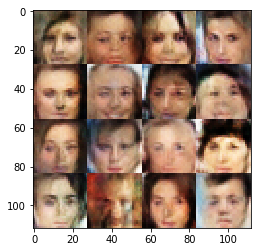

Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.5844


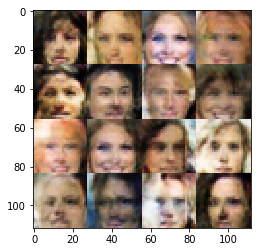

Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8570


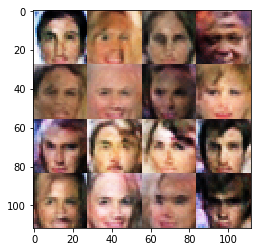

Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7260


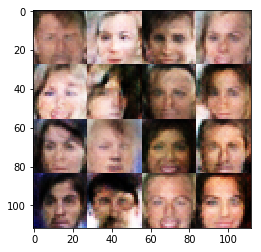

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.9541


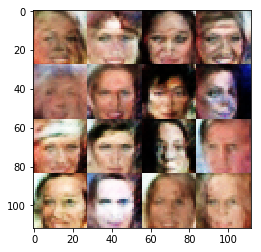

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.6184


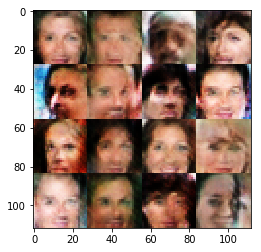

Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.8030


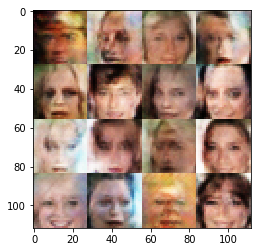

Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.8860


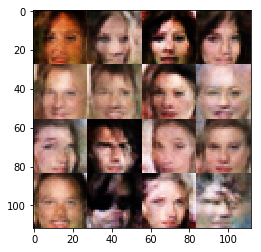

Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8054


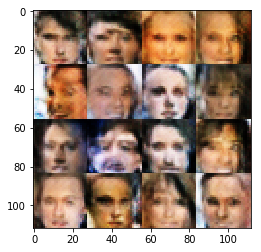

Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.6793


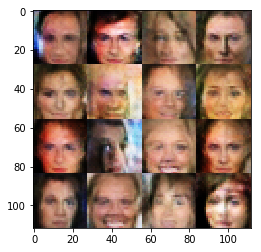

Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6308


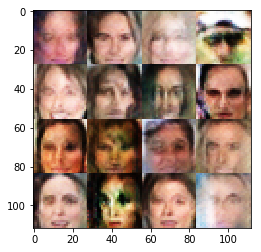

Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.8256


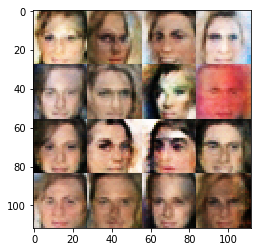

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7027


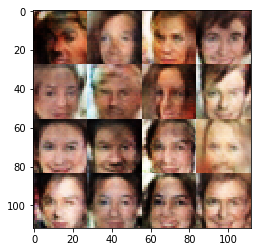

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8301


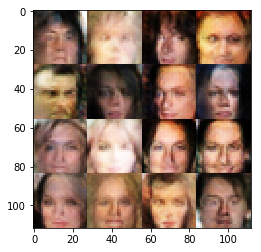

Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7803


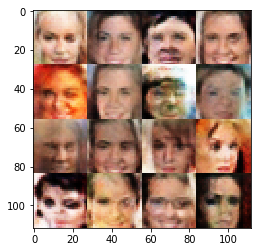

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.8969


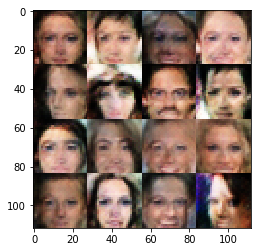

Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7543


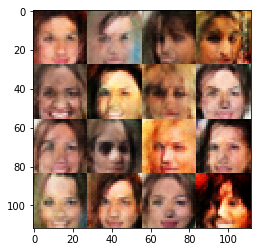

Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.7800


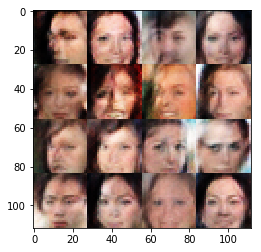

Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.5552


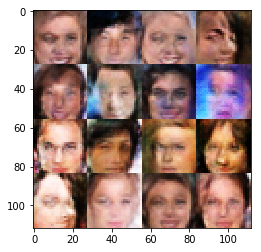

Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7988


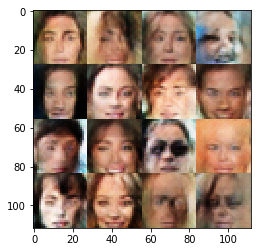

Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8219


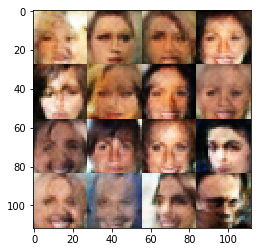

Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.8582


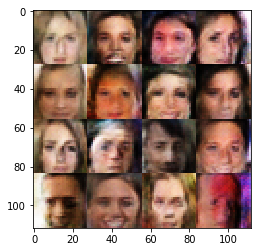

Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.9289


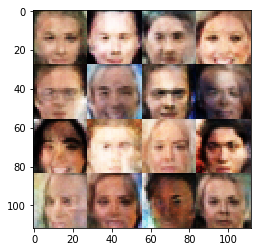

Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.7747


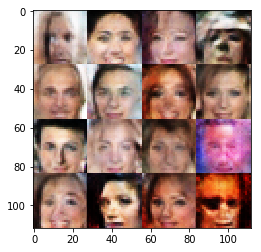

Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9203


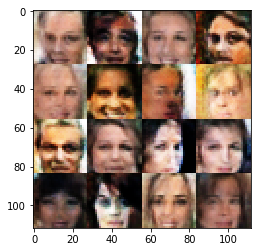

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8190


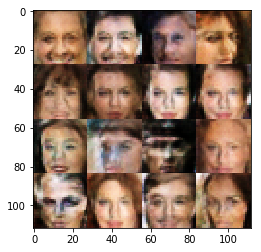

In [51]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。